In [1]:
import tqdm
from typing import Callable, Dict, Optional, Tuple, Union
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import torch

from adaptive_mcmc.distributions.distribution import GaussianMixture
from adaptive_mcmc.samplers import samplers, base_sampler
from adaptive_mcmc.samplers.stopping_rule import TVStop, NoStop
from adaptive_mcmc.tools.benchmark import BenchmarkUtils, Benchmark

2024-12-30 20:45:09.647666: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735580709.656835    9920 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735580709.659531    9920 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
seed = 123
torch.manual_seed(seed)

device = "cpu"

base_meta = {
    "sigma": 1.,
    "sigma_lr": 0.015,
    "target_acceptance": 0.574,
    "device": device,
}

meta_fisher = {
    "dampening": 10,
}

In [3]:
chain_count = 5
dimensions = [1000, 2, 5, 10, 100]
gaussian_count = 5
distance_to_mass_points = 1.
tv_threshold = 0.05
sample_count = 500
sample_iter_limit = 2000
burn_in_iter_count = 1000
probe_period = 100
cube = 1.
tail_count_cap = 1000

# stopping_rule = TVStop(threshold=tv_threshold, density_probe_count=1000,
#                        projection_count=25, tail_count_cap=tail_count_cap)

stopping_rule = NoStop(density_probe_count=500,
                       projection_count=25, tail_count_cap=tail_count_cap)

algs = {
    "fisher_mala": samplers.FisherMALAVanilla(
        pipeline=None,
        sigma_burn_in_params=base_meta.copy(),
        sigma_burn_in_iter_count=500,
        prec_burn_in_params=meta_fisher.copy(),
        prec_burn_in_iter_count=burn_in_iter_count - 500,
        sample_iter_count=sample_iter_limit,
        stopping_rule=stopping_rule,
        probe_period=probe_period
    ),
    "mala": samplers.MALAVanilla(
        pipeline=None,
        sigma_burn_in_params=base_meta.copy(),
        sigma_burn_in_iter_count=burn_in_iter_count,
        sample_iter_count=sample_iter_limit,
        stopping_rule=stopping_rule,
        probe_period=probe_period
    ),
}

hist_data = {}
runtime = {
    dimension: dict()
    for dimension in dimensions
}

for dimension in tqdm.notebook.tqdm(dimensions):
    print("Processing dimension", dimension)
    hist_data[dimension] = {}

    true_means = torch.rand((gaussian_count, dimension)) * cube - cube / 2
    true_covs = torch.rand((gaussian_count, dimension, dimension))
    true_covs = (
        true_covs @ true_covs.permute(0, 2, 1) +
        torch.eye(dimension).repeat(gaussian_count, 1, 1)
    )

    gm = GaussianMixture(
        true_means,
        true_covs,
        torch.full((gaussian_count,), 1/gaussian_count, dtype=torch.float64)
    )

    starting_points = BenchmarkUtils.generate_starting_points(
        chain_count, dimension,
        true_means,
        distance_to_mass_points,
    )
    true_samples = gm.sample(sample_count)

    params = base_sampler.Params(
        target_dist=gm,
        starting_point=starting_points,
        proposal_dist=torch.distributions.MultivariateNormal(
            torch.zeros(dimension, device=device),
            torch.eye(dimension, device=device),
        ),
    )
    base_meta_adj = base_meta.copy()
    base_meta_adj["sigma"] /= dimension

    for alg in algs:
        print("-" * 80)
        params.meta = base_meta_adj.copy()

        algs[alg].load_params(params)
        algs[alg].load_true_samples(true_samples)
        algs[alg].run()

        hist_data[dimension][alg] = [
            algs[alg].pipeline.sample_blocks[-1].iteration.cache,
            algs[alg].pipeline.sample_blocks[-1].stop_data_hist
        ]
        runtime[dimension][alg] = algs[alg].pipeline.runtime
    print()

  0%|          | 0/5 [00:00<?, ?it/s]

Processing dimension 1000
--------------------------------------------------------------------------------
Running FisherMALA
number of blocks: 3
processing block: 1


  0%|          | 0/500 [00:00<?, ?it/s]

processing block: 2


  0%|          | 0/500 [00:00<?, ?it/s]

processing block: 3


  0%|          | 0/2000 [00:00<?, ?it/s]

Runtime: 377.08s
--------------------------------------------------------------------------------
Running MALA
number of blocks: 2
processing block: 1


  0%|          | 0/1000 [00:00<?, ?it/s]

processing block: 2


  0%|          | 0/2000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [4]:
tv_threshold = 0.05

In [ ]:
runtime

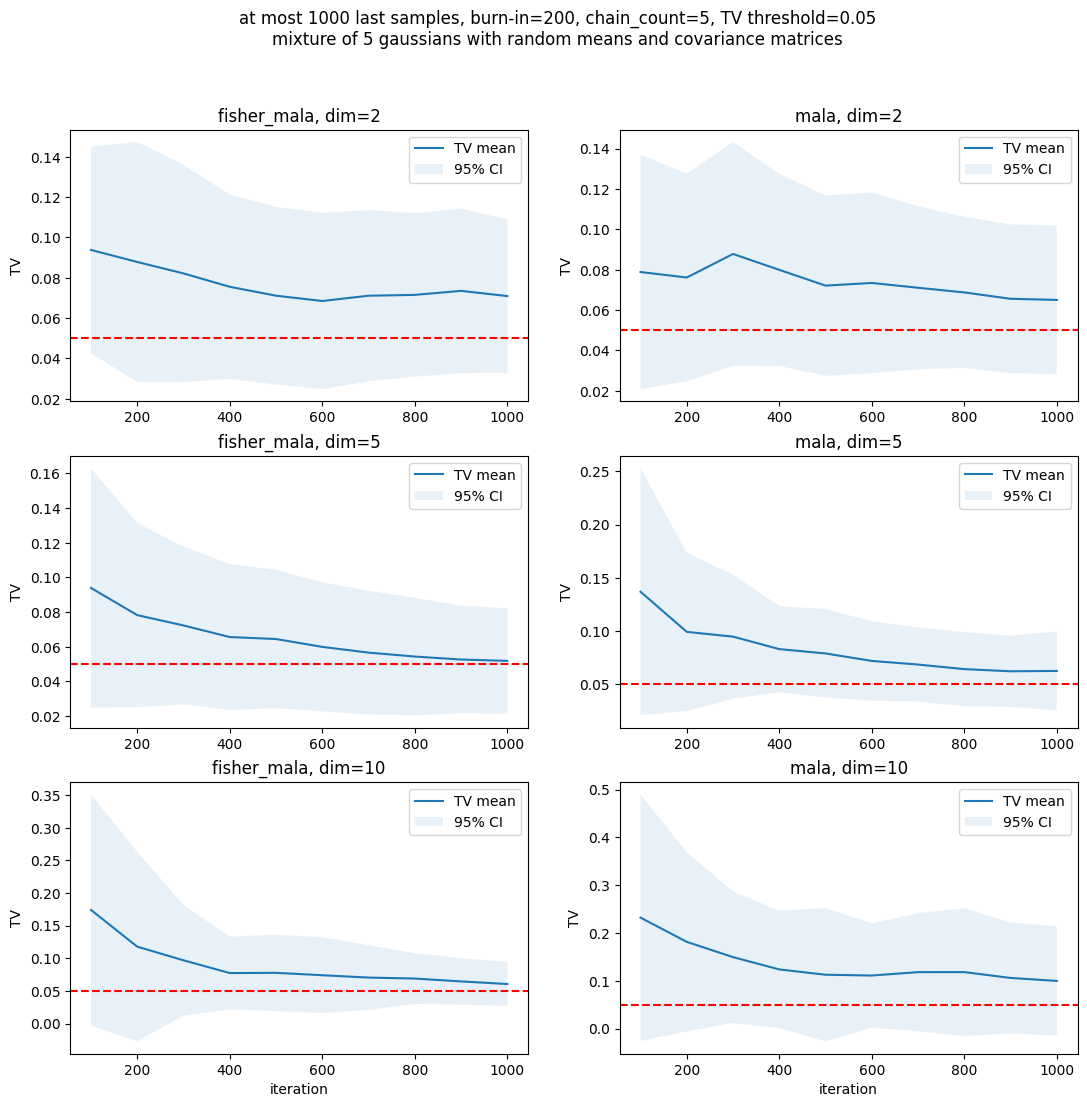

In [12]:
fig, axes = plt.subplots(
    nrows=len(dimensions),
    ncols=2,
    figsize=(13, 4 * len(dimensions),)
)
fig.suptitle(
    f"at most {tail_count_cap} last samples, burn-in={burn_in_iter_count}, "
    f"chain_count={chain_count}, "
    f"TV threshold={tv_threshold}\n" +
    f"mixture of {gaussian_count} gaussians with "
    "random means and covariance matrices"
)

for dim_ind in range(len(dimensions)):
    for alg_ind, alg in enumerate(algs.keys()):

        ticks_count = len(hist_data[dimensions[dim_ind]][alg][1])
        xticks = probe_period * jnp.arange(1, ticks_count + 1)

        axes[dim_ind, alg_ind].plot(
            xticks,
            [
                entry["tv_mean"]
                for entry in hist_data[dimensions[dim_ind]][alg][1]
            ],
            label="TV mean"
        )
        axes[dim_ind, alg_ind].fill_between(
            xticks,
            [
                entry["tv_mean"] - 2 * entry["tv_std"]
                for entry in hist_data[dimensions[dim_ind]][alg][1]
            ],
            [
                entry["tv_mean"] + 2 * entry["tv_std"]
                for entry in hist_data[dimensions[dim_ind]][alg][1]
            ],
            alpha=0.1,
            label="95% CI"
        )
        axes[dim_ind, alg_ind].axhline(tv_threshold, color="r", linestyle="dashed")
        axes[dim_ind, alg_ind].set_title(f"{alg}, dim={dimensions[dim_ind]}")
        if dim_ind + 1 == len(dimensions):
            axes[dim_ind, alg_ind].set_xlabel("iteration")
        axes[dim_ind, alg_ind].set_ylabel("TV")
        axes[dim_ind, alg_ind].legend()

In [6]:
BenchmarkUtils.compute_metrics(
    algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

{'ess': np.float32(0.06777337),
 'tv_mean': Array(0.08048456, dtype=float32),
 'tv_conf_sigma': Array(0.02950848, dtype=float32),
 'wasserstein': 14.736303207718791}

In [7]:
BenchmarkUtils.compute_metrics(
    algs["mala"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["mala"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

{'ess': np.float32(0.03398408),
 'tv_mean': Array(0.1385354, dtype=float32),
 'tv_conf_sigma': Array(0.06926993, dtype=float32),
 'wasserstein': 21.141160609177447}

### Reference

In [8]:
BenchmarkUtils.compute_metrics(
    algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["fisher_mala"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

{'ess': np.float32(0.06777337),
 'tv_mean': Array(0.08048456, dtype=float32),
 'tv_conf_sigma': Array(0.02950848, dtype=float32),
 'wasserstein': 14.736303207718791}

In [9]:
BenchmarkUtils.compute_metrics(
    algs["mala"].pipeline.sample_blocks[-1].iteration.cache.samples,
    algs["mala"].pipeline.sample_blocks[-1].iteration.cache.true_samples
)

{'ess': np.float32(0.03398408),
 'tv_mean': Array(0.1385354, dtype=float32),
 'tv_conf_sigma': Array(0.06926993, dtype=float32),
 'wasserstein': 21.141160609177447}